In [29]:
import os

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [31]:
url ='https://raw.githubusercontent.com/C4AnN/Models/main/dataset_processing%20(2)/filtered_data_mid_level2.csv'
store_sales = pd.read_csv(url)
store_sales.head(10)

,name,price,date,sales
0,monsters gaming asus rog gl553vd i7 7700hq 16g...,13750000,2013-01-12,7
1,Asus ROG G531GT I565B1T i5 9300 8GB 512ssd GTX...,13349000,2013-01-17,16
2,Asus Slim Monster Gaming ROG GL502VM w/ GTX 10...,14999000,2013-01-26,12
3,LENOVO L340 15IRH-1UID GAMING i7-9750 8GB 512s...,12749000,2013-01-29,6
4,MSI BRAVO 15 Ryzen 5 4600 8GB 256ssd RX5500M 4...,12549000,2013-01-30,9
5,Asus ROG Monster Slim Gaming GL702VM i7 w/ GTX...,15999000,2013-02-02,21
6,LENOVO L340 15IRH-1UID GAMING i7-9750 8GB 512s...,12749000,2013-02-07,13
7,MSI BRAVO 15 Ryzen 5 4600 8GB 256ssd RX5500M 4...,12549000,2013-02-08,11
8,ASUS ROG G531GT-I565G1T/ I5 9300HQ-8GB-SSD 512...,12800000,2013-02-17,11
9,ASUS ROG GL551VW-DS71 Gaming Notebook,15950000,2013-02-19,10


In [32]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47120 entries, 0 to 47119
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    47120 non-null  object
 1   price   47120 non-null  int64 
 2   date    47120 non-null  object
 3   sales   47120 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [33]:
store_sales = store_sales.drop(['name','price'], axis=1)

In [34]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47120 entries, 0 to 47119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    47120 non-null  object
 1   sales   47120 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 736.4+ KB


In [35]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [36]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47120 entries, 0 to 47119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    47120 non-null  datetime64[ns]
 1   sales   47120 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 736.4 KB


In [37]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [38]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [39]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,15652
1,2013-02-01,14591
2,2013-03-01,20371
3,2013-04-01,24250
4,2013-05-01,27655
5,2013-06-01,29305
6,2013-07-01,27577
7,2013-08-01,26107
8,2013-09-01,21592
9,2013-10-01,21810


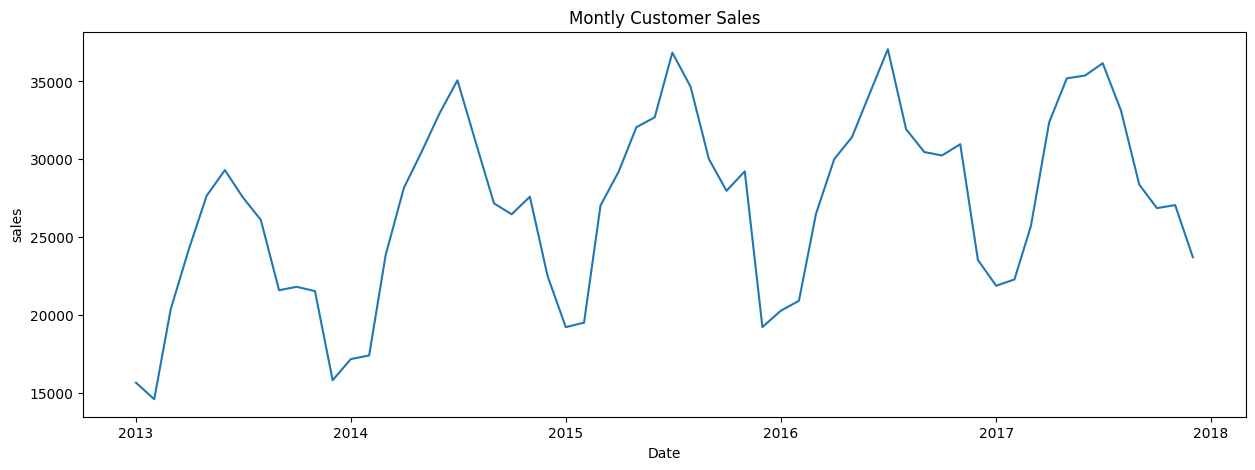

In [40]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("sales")
plt.title("Montly Customer Sales")
plt.show()

In [41]:
# Sales_diff = Selisih Total Penjualan Dengan Bulan Sebelumnya (Increase (+) atau Decrease (-) )
# Contoh Sales_diff pada Row 2 date 2013-03-01 didapatkan dari
# jumlah sales pada date 2013-03-01 (617382) - date 2013-02-01 (459417) didapatkan sales_diff = 157965.0

monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,14591,-1061.0
2,2013-03-01,20371,5780.0
3,2013-04-01,24250,3879.0
4,2013-05-01,27655,3405.0
5,2013-06-01,29305,1650.0
6,2013-07-01,27577,-1728.0
7,2013-08-01,26107,-1470.0
8,2013-09-01,21592,-4515.0
9,2013-10-01,21810,218.0
10,2013-11-01,21533,-277.0


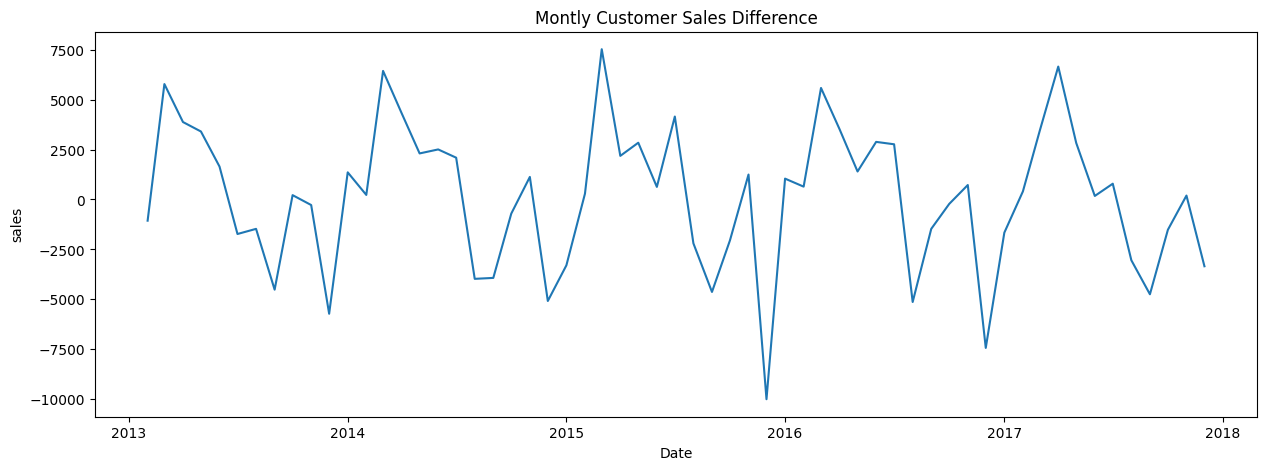

In [42]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel("Date")
plt.ylabel("sales")
plt.title("Montly Customer Sales Difference")
plt.show()

In [43]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

In [44]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,229.0,1360.0,-5721.0,-277.0,218.0,-4515.0,-1470.0,-1728.0,1650.0,3405.0,3879.0,5780.0,-1061.0
1,6439.0,229.0,1360.0,-5721.0,-277.0,218.0,-4515.0,-1470.0,-1728.0,1650.0,3405.0,3879.0,5780.0
2,4322.0,6439.0,229.0,1360.0,-5721.0,-277.0,218.0,-4515.0,-1470.0,-1728.0,1650.0,3405.0,3879.0
3,2307.0,4322.0,6439.0,229.0,1360.0,-5721.0,-277.0,218.0,-4515.0,-1470.0,-1728.0,1650.0,3405.0
4,2507.0,2307.0,4322.0,6439.0,229.0,1360.0,-5721.0,-277.0,218.0,-4515.0,-1470.0,-1728.0,1650.0
5,2094.0,2507.0,2307.0,4322.0,6439.0,229.0,1360.0,-5721.0,-277.0,218.0,-4515.0,-1470.0,-1728.0
6,-3973.0,2094.0,2507.0,2307.0,4322.0,6439.0,229.0,1360.0,-5721.0,-277.0,218.0,-4515.0,-1470.0
7,-3926.0,-3973.0,2094.0,2507.0,2307.0,4322.0,6439.0,229.0,1360.0,-5721.0,-277.0,218.0,-4515.0
8,-706.0,-3926.0,-3973.0,2094.0,2507.0,2307.0,4322.0,6439.0,229.0,1360.0,-5721.0,-277.0,218.0
9,1130.0,-706.0,-3926.0,-3973.0,2094.0,2507.0,2307.0,4322.0,6439.0,229.0,1360.0,-5721.0,-277.0


In [45]:
# Previous 12 Month
train_data = supervised_data[:-12]
# The Coming 12 Month
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


In [46]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [47]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("x_test shape : ", X_test.shape)
print("y_test shape : ", y_test.shape)

x_train shape :  (35, 12)
y_train shape :  (35,)
x_test shape :  (12, 12)
y_test shape :  (12,)


In [48]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [49]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[23536, 21876, 22282, 25712, 32368, 35198, 35375, 36166, 33124, 28378, 26862, 27059, 23716]


In [50]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)

In [51]:
lr_pre = lr_pre.reshape(-1,1)
# This is a set matrix - contain the input features of the data, and also the predict output
lr_pre_test_set = np.concatenate([lr_pre, X_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [52]:
result_list= []
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

In [53]:
# print(predict_df)
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print("Linaer Regression MSE : ", lr_mse )
print("Linaer Regression MAE : ", lr_mae )
print("Linaer Regression R2 : ", lr_r2 )

Linaer Regression MSE :  2553.8131270066287
Linaer Regression MAE :  2133.7602779717568
Linaer Regression R2 :  0.7588825145865382


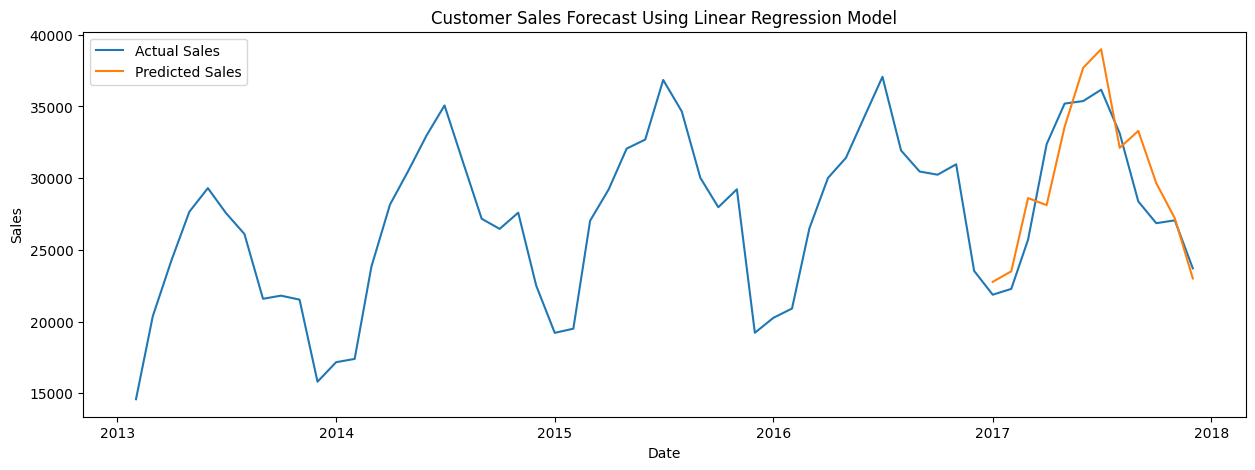

In [54]:
plt.figure(figsize=(15,5))
# Actual Sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted Sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Customer Sales Forecast Using Linear Regression Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()